### Ce notebook permet de calculer le beam power dans une zone souhaitée du beam, et est utilisé afin de tracker non pas l'amplitude max du beam, mais le beam power pour les divers jours, afin de pouvoir comparer ce beam power avec les autres paramètres comme amplitude aux station, taille vauges et l'amplitude dans le modèle océanique

In [2]:
#on fait le code pour extract le beam noise power au lieu de juste prendre le max -> devrait réduire les oscillations 
from functions import *
%matplotlib ipympl

def compute_beam_power(date1,date2,blend=False,baz_range=None,slow_range=None):
    '''On doit lui input les dates sous forme de tuple (year,month,day)
    Si l'argument blend est passé en true, alors il va mélanger les beams sucessifs, permettant ainsi de doubler le nombre de points (12h du jour 1 de blend)'''
    day1 = date_to_day(date1) #calcul du jour de l'année
    day2 = date_to_day(date2)
    year1 = date1[0]
    year2 = date2[0]
    if year1!=year2: #if they are not the same year -> then we need to perform a concatenation over the years 
        
        if blend==True:
            day_range1 = np.arange(day1,366-0.5,0.5)
            day_range2 = np.arange(1,day2-0.5,0.5)
        else:
            day_range1 = range(day1,366) #on fait la range de jours dans l'année pour savoir quels fichiers inclure dans l'array
            day_range2 = range(1,day2) 
        
        amplitude_matrix1= extract_beam_power(year1,day_range1,blend=blend,baz_range=baz_range,slow_range=slow_range) #on récupère tous les fichiers dans l'année 1 et on extrait les valeurs + calcule les velo + baz
        amplitude_matrix2= extract_beam_power(year2,day_range2,blend=blend,baz_range=baz_range,slow_range=slow_range)
        
        amplitude_matrix_all = np.concatenate((amplitude_matrix1,amplitude_matrix2),axis=1) 
        dates_range = compute_dates_range(date1,date2,blend=blend)
    else:
        if blend==True:
            day_range = np.arange(day1,day2-0.5,0.5)
        else:
            day_range = range(day1,day2)
            
        amplitude_matrix_all = extract_beam_power(year1,day_range,blend=blend,baz_range=baz_range,slow_range=slow_range) #peu importe qu'on utilsie l'anéne de la première date ou de la deuxième puisque la même
        dates_range = compute_dates_range(date1,date2,blend=blend)
    return dates_range, amplitude_matrix_all[0,:]  


def remove_badbeams_beam_power(dates_range,amplitude_matrix, dates_to_rm=None):
    print(f'Removing listed bad beams... {len(dates_to_rm)} beams to remove in total')
    # kept_dates = []
    # kept_amplitude = []
    for i in range(len(dates_range)):
        counter = 0
        for j in range(len(dates_to_rm)):
            counter+=np.count_nonzero(dates_to_rm[j]==dates_range[i]) #obligé d'itérer comme ça avec ces objets 
        if counter!=0: #si counter = 0 ça veut dire que aucun des jours à remove correspond au jour considéré, donc que le jour doit bien être cobservé !  
            amplitude_matrix[i] = np.nan 
            # kept_dates.append(dates_range[i])
            # kept_amplitude.append(amplitude_matrix[i])
    # kept_amplitude = np.array(kept_amplitude)
    # print(f'Number of dates remaining : {len(kept_dates)} ({len(dates_range)-len(kept_dates)} removed)')
    return dates_range, amplitude_matrix


def remove_nowave_beam_power(dates_range,amplitude_matrix):
    # kept_dates = []
    # kept_amplitude = []
    for i in range(len(dates_range)):
        if amplitude_matrix[i]==0: #si counter = 0 ça veut dire que aucun des jours à remove correspond au jour considéré, donc que le jour doit bien être cobservé !  
            # kept_dates.append(dates_range[i])
            # kept_amplitude.append(amplitude_matrix[i])
            amplitude_matrix[i] = np.nan
    # kept_amplitude = np.array(kept_amplitude)
    return dates_range, amplitude_matrix


def plot_beam_power(dates_range,amplitude_matrix, threshold_sta=0,
                   rm_nowave=False, figname=None, rm_badbeams=None, amp_threshold=None,):
    plt.close('all')
    #first we remove what we don't want to see in our data
    # if threshold_sta >0:
    #     dates_range, veloc_matrix, baz_matrix, amplitude_matrix, incert_veloc_matrix,incert_baz_matrix = remove_days(dates_range, veloc_matrix, baz_matrix,amplitude_matrix,
                                                                                    # incert_veloc_matrix,incert_baz_matrix,threshold_sta)
    #on va chercher la freq range en utilisant un fichier quelconque
    beam_file = f"{in_['beam_dir']}/beam_{compo_to_plot}_2001_day_275.h5"
    data = h5py.File(beam_file,'r')
    freqs = data['ff']['sfreq'][()]
    ifreq = m_beam.make_short_freq(pl_updated['fn'][0],freqs,fw=pl_updated['fw'],nf=0) #calcule la gamme de fréquences utilisées avec le compute evolution!
    #we can plot now
    fig, ax = plt.subplots(figsize=(13,4))
    fig.suptitle(f"Temporal evolution of Velocity and Back Azimuth for frequencies in range {round(freqs[ifreq[0]],2)}-{round(freqs[ifreq[-1]],2)}Hz")
    ax.set_xlabel('Dates')
    
    dates_range, amplitude_matrix = remove_nowave_beam_power(dates_range,amplitude_matrix)
    
    # if amp_threshold!=None:
    #     dates_range, veloc_matrix, baz_matrix,amplitude_matrix, incert_veloc_matrix, incert_baz_matrix = remove_low_amp(dates_range,veloc_matrix, baz_matrix,
                                                                                                            # amplitude_matrix,incert_veloc_matrix,incert_baz_matrix, amp_threshold)    
    if rm_badbeams!=None: #on retire la liste des dates où les beams sont mauvais
        dates_range, amplitude_matrix = remove_badbeams_beam_power(dates_range,amplitude_matrix, rm_badbeams)

    ax.plot(dates_range,amplitude_matrix, marker='.', color='red')
    
    if figname!=None:
        print('file saved')
        plt.savefig(figname,bbox_inches='tight',dpi=300)        
        
    return dates_range, amplitude_matrix


def extract_beam_power(year, days, blend=False,baz_range=None,slow_range=None):
    amplitude_matrix = np.zeros((1,len(days)))
    print(f'Processing {year} data, please wait...')  
    for i in tqdm(range(len(days))):
        if int(days[i])!=days[i]: #si blend est true, alors il y a des floats .5 et donc cette égalité est pas respectée 
            day_first = int(days[i])
            day_second = day_first+1
            data1 = h5py.File(f"{in_['beam_dir']}/beam_{bb['compo']}_{year}_day_{day_first:03}.h5",'r') 
            data2 = h5py.File(f"{in_['beam_dir']}/beam_{bb['compo']}_{year}_day_{day_second:03}.h5",'r')
            fk1   = data1['fk'][()]
            fk2   = data2['fk'][()]
            freqs = data1['ff']['sfreq'][()]   #ça devrait pas matter si on prend depuis le 1 ou le 2
            U    = data1['bb']['U'][()] * 10**3 #doit direct utiliser U pour les calculs avec x et y!!!
        else: #si respectée 2 poss, soit c'est que c'est blend mais jour full soit c'est pas blend et donc déjà int
            if isinstance(days[i], float)==True: #si c'est in float alors on le reconverti en int
                day = int(days[i])
            else:
                day = days[i]
            data = h5py.File(f"{in_['beam_dir']}/beam_{bb['compo']}_{year}_day_{day:03}.h5",'r') #il importe le fichier 
            fk   = data['fk'][()]
            freqs = data['ff']['sfreq'][()]
            U    = data['bb']['U'][()] * 10**3
        
        
        #on doit d'abord vérifier qu'il  y a de la donnée ce jour là histoire d'éviter un crash! 
        availability_matrix = np.loadtxt('availability_matrix_nobad')
        
        #on doit calculer le nombre de stations, pour ça, soit c'est un jour et ez, soit c'est deux jours et alors on prend le nb minmum entre les deux
        if int(days[i])!=days[i]:
            idx_availability1 = installed_days(year, day_first)
            idx_availability2 = installed_days(year, day_second)
            sta_number1 = np.count_nonzero(availability_matrix[:,idx_availability1]==1)
            sta_number2 = np.count_nonzero(availability_matrix[:,idx_availability2]==1)
            sta_number = np.min([sta_number1,sta_number2])
            if day_first==102 or day_second==102:
                sta_number = 0 #on truque pour que 102 fasse pas planter 
        else:#on peut direct utiliser day ici, car calculé précéemment 
            idx_availability = installed_days(year, day)
            sta_number = np.count_nonzero(availability_matrix[:,idx_availability]==1)
        
        if sta_number>0 and days[i]!=102: #s'assure d'avoir de la donnée avant d'essayer de faire le beamforming
            for j in range(len(pl_updated['fn'])):
                ifreq = m_beam.make_short_freq(pl_updated['fn'][j],freqs,fw=pl_updated['fw'],nf=0)
                
                if int(days[i])!=days[i]:   #pareil, si on est sur un .5, alors on doit blend les deux jours!! 
                    Z1 = np.mean(np.abs(fk1[ifreq,:,:]),axis=0).transpose()
                    Z2 = np.mean(np.abs(fk2[ifreq,:,:]),axis=0).transpose()
                    Z  = (Z1+Z2)/2 #on fait la moyenne des beams des deux jours différents !
                else: #si int(days) = days alors c'est qu'on est sur un jour spécifique et donc on a déjà son Z grâce au fk
                    Z = np.mean(np.abs(fk[ifreq,:,:]),axis=0).transpose() #on a supprimé l'option pour faire la déconvol car travaille qu'en bartlett
                #on passe en échelle db si besoin !
                
                #maintenant que l'on a correctement traité Z, il a la même alors que sur les plots de beam, et donc les valeurs extraites sont les mêmes que celles
                #attendues à partir des panneaux de beam !
                #doit chercher les indices de début et fin de la zone dans le beam qui nous intéresse  -> comme ça on prendre en compte que le beam noise power
                #dans la bonne région 
                amplitude_matrix[0,i] = compute_amplitude(U,Z,baz_range=baz_range,slow_range=slow_range) #calcul le noise power
        else:
            for j in range(len(pl_updated['fn'])):
                amplitude_matrix[0,i] = 0
    return amplitude_matrix


def compute_amplitude(U,Z,slow_range=None,baz_range=None):
    if baz_range==None:
        xmin, xmax,ymin, ymax = np.argmin(np.abs(U-(-0.3))), np.argmin(np.abs(U-(-0.1))), np.argmin(np.abs(U-(-0.25))), np.argmin(np.abs(U-(0.1)))
        amp = np.mean(Z[ymin:ymax+1, xmin:xmax+1])
    else:# ici on va lui faire masquer la région qui n'est pas dans la bonne gamme de slowness et back azimuth
        #pour ça on lui donne une matrice dans laquelle les éléments qui n'ont pas la bonne slowness et le bon baz sont transformés en nan
        slow_mesh, baz_mesh = np.zeros((len(U),len(U))), np.zeros((len(U),len(U)))   
        for j in range(len(U)):
            for i in range(len(U)):
                slow_mesh[j,i] = 1/compute_velo(([j],[i]),U) 
                baz_mesh[j,i] = compute_baz(([j],[i]),U)
        slow_idx = np.where((slow_range[0]<=slow_mesh) & (slow_mesh<=slow_range[1]))
        slow_mask = np.zeros(slow_mesh.shape)*np.nan
        slow_mask[slow_idx] = 1
        baz_idx = np.where((baz_mesh>=baz_range[0]) & (baz_mesh<=baz_range[1]))
        baz_mask = np.zeros(baz_mesh.shape)*np.nan
        baz_mask[baz_idx] = 1
        Z_nan = Z*slow_mask*baz_mask
        amp = np.mean(Z_nan[np.where(np.isnan(Z_nan)==False)]) 
    return amp

In [3]:
#calcul du baz de la station WIS histoire de savoir dans quelle partie du beam comparer à cette station ... 
lon_bary, lat_bary, height_bary = compute_barycenter('stations_rm_nobad.txt')
wis_lat,wis_lon = 35.770,-121.903
baz = gps2dist_azimuth(wis_lat, wis_lon, lat_bary,lon_bary)[2]
print('baz = ',baz, '°') 

baz =  259.7209098320125 °


In [4]:
#on si on importe le fichier variables de la version classic des beams alors on sort le profil fait sur les beams classics normalement 
#à fair epour voir si c'est le bartlett qui pose problème ...

pl_updated['fn'] = [1.0]
pl_updated['fw'] = 1.2**(1/6) #pour faire pile à 1Hz!


# peut indiquer une gamme de slowness et baz pour extract l'maplitude du beam, cette méthode est super pratique si on veut target un baz
#particulier par ex pour mieux comparer avec évolution de l'amplitude à une station WIS
slow_range = None#[0.15,0.27] #None 
baz_range = None #[255,265]  #None 

date1 = (2001,10,2)
date2 = (2002,6,4)

dates_beam_power, beam_power = compute_beam_power(date1,date2,blend=False,slow_range=slow_range,baz_range=baz_range)

Processing 2001 data, please wait...


100%|████████████████████████████████████████████████████████████████| 91/91 [04:12<00:00,  2.78s/it]


Processing 2002 data, please wait...


100%|██████████████████████████████████████████████████████████████| 154/154 [06:22<00:00,  2.48s/it]


Removing listed bad beams... 32 beams to remove in total


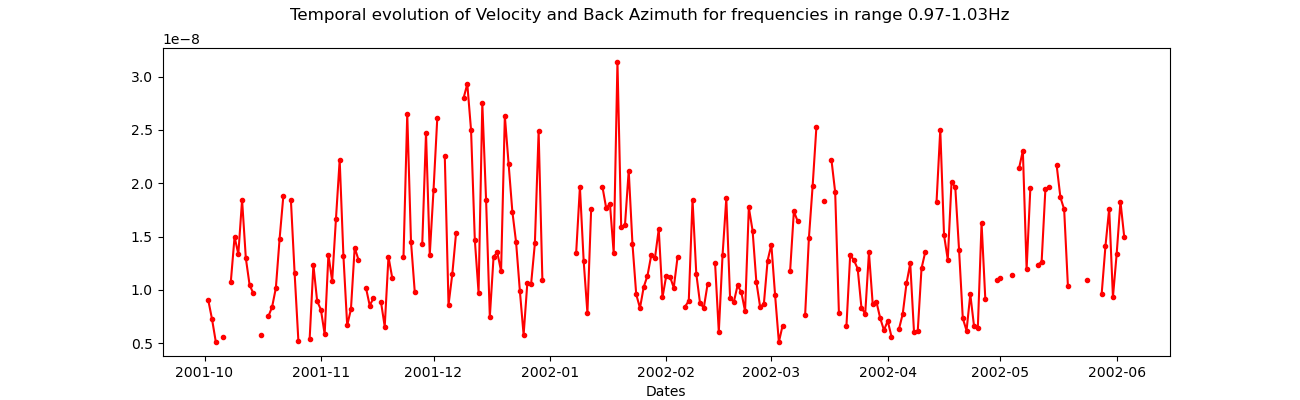

In [6]:
# badbeam_list = [datetime(2001,10,6,12),datetime(2001,10,7),datetime(2001,10,7,12),  #jours 279.5, 280 et 280.5
#                 datetime(2001,10,22,12),datetime(2001,10,23),datetime(2001,10,23,12), #jours atours de 296
#                 datetime(2001,11,15,12),datetime(2001,11,16),datetime(2001,11,16,12), #jours autour 320
#                 datetime(2001,11,20,12),datetime(2001,11,21),datetime(2001,11,21,12), #jours autour 325
#                 datetime(2001,11,26,12),datetime(2001,11,27),datetime(2001,11,27,12), #jours autour 331
#                 datetime(2001,12,30,12),datetime(2001,12,31), #jour autour de 365
#                 datetime(2002,2,4,12), datetime(2002,2,5), datetime(2002,2,5,12), # jour 36
#                 datetime(2002,2,12,12), datetime(2002,2,13), datetime(2002,2,13,12), # jour 44
#                 datetime(2002,4,13), datetime(2002,4,13,12), # jour 103 et 103.5
#                 datetime(2002,4,28,12),datetime(2002,4,29),datetime(2002,4,29,12), #jour 119
#                 datetime(2002,5,1,12),datetime(2002,5,2),datetime(2002,5,2,12),datetime(2002,5,3),datetime(2002,5,3,12), #début mai 
#                 datetime(2002,5,4,12),datetime(2002,5,5),datetime(2002,5,5,12), #jour 125
#                 datetime(2002,5,9,12),datetime(2002,5,10),datetime(2002,5,10,12), #jour 130
#                 datetime(2002,5,23),datetime(2002,5,23,12), #jour 143 et 143.5
#                 datetime(2002,5,24,12),datetime(2002,5,25),datetime(2002,5,25,12),datetime(2002,5,26),datetime(2002,5,26,12) #fin mai 144.5-146.5
#                 ]

badbeam_list_classic = [datetime(2001,10,5),datetime(2001,10,7),datetime(2001,10,15),datetime(2001,10,17),datetime(2001,10,23),datetime(2001,10,27),
                        datetime(2001,10,28),datetime(2001,11,12),datetime(2001,11,16),datetime(2001,11,21),datetime(2001,11,22),datetime(2001,11,27),
                        datetime(2001,12,8),datetime(2001,12,31),datetime(2002,2,5),datetime(2002,2,5),datetime(2002,2,13),datetime(2002,3,5),datetime(2002,3,9),
                       datetime(2002,3,20),datetime(2002,4,3),datetime(2002,4,13),datetime(2002,4,28),datetime(2002,4,29),datetime(2002,5,2),
                       datetime(2002,5,3),datetime(2002,5,5),datetime(2002,5,10),datetime(2002,5,23),datetime(2002,5,25),datetime(2002,5,26),
                       datetime(2002,5,27)]


dates_beam_power_clean, beam_power_clean = plot_beam_power(dates_beam_power,beam_power, rm_badbeams=badbeam_list_classic)


#retiré les jours avec bad beams et rétiré les jours où pas de donnée, ça devrait être largement suffisant pour comparer à partir de maintenant on exporte donc 

# write_datetime_list_to_file('dates_beampower_daily.txt', dates_beam_power_clean)

np.save('amp_beampower_daily_classic_1.0Hz.npy', beam_power_clean) #on le fait mais focus sur 1 Hz pour être safe 

In [24]:
U = np.arange(-0.3,0.3,0.01)
Z = np.ones((len(U), len(U)))

slow_range = [0.15,0.25]
baz_range = [225,250]

compute_amplitude(U,Z,slow_range,baz_range,mode='t')

1.0